# Deep Learning Assignment 3 - Part 2
### Latent Space Visualization

Student 1: Ramiz Srour, 314855446

Student 2: Or Dinar, 207035809

# Imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from IPython.display import Video
import cv2

# Preprocessing

In [2]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '~/datasets'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)

# create train and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting /root/datasets/MNIST/raw/train-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]


Extracting /root/datasets/MNIST/raw/train-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.86MB/s]


Extracting /root/datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/datasets/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 7.10MB/s]


Extracting /root/datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/datasets/MNIST/raw



# Encoder Class
Implementation according to Tutorials:
Defined the Encoder with 2 fully connected layers (as mentioned below) and a Leaky ReLU activation function.
Leaky ReLU can provide a non-zero output for negative input values, which can help to avoid discarding information (Did better than ReLU).

In [3]:
class Encoder(nn.Module):

    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        # First fully connected layer: Input -> Hidden
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        # Second fully connected layer: Hidden -> Latent space
        self.fc2 = nn.Linear(hidden_dim, latent_dim)
        # LeakyReLU activation function, works better than ReLU
        self.relu = nn.LeakyReLU(0.2)

    def forward(self, x): #Pass input through encoder and return latent representation.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)

        return x


Implementation according to Tutorials: Defined the Decoder with 3 fully connected layers (as mentioned below) , Leaky ReLU and Sigmoid activation function.
Leaky ReLU can provide a non-zero output for negative input values, which can help to avoid discarding information.
Sigmoid allowed better results.

# Decoder Class

In [4]:
class Decoder(nn.Module):

    def __init__(self, output_dim=784, hidden_dim=400, latent_dim=200):
        super(Decoder, self).__init__()
        # First fully connected layer: Latent space (2D) → Latent dimension
        self.fc1 = nn.Linear(2, latent_dim)
        self.relu = nn.LeakyReLU(0.2)
        # Second fully connected layer: Latent dimension → Hidden dimension
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        # Third fully connected layer: Hidden dimension → Output dimension
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x): #Pass latent representation through decoder, outputs a reconstructed image.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

# Variational Auto Encoder Class
This class includes the encoder and the decoder,

Architecture includes both the encoder and the decoder defined above, with a mean and log variance layers.
Forward function passes X through the encoder, extracts the mean and log variance, passes those through the reparameterization trick as learned in the tutorial/lecture, and only afterwards is passed to the decoder.

In [5]:
class VAE(nn.Module):

    def __init__(self, input_dim=784, hidden_dim=400, latent_dim=200, device=device):
        super(VAE, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim) # Encoder
        self.decoder = Decoder(input_dim, hidden_dim, latent_dim) # Decoder
        self.mean_layer = nn.Linear(latent_dim, 2) # Mean of latent representation
        self.logvar_layer = nn.Linear(latent_dim, 2) # Log variance of latent distribution

    def forward(self, x): # Forward Pass through VAE, return x_hat, mean, logvar
        x = self.encoder.forward(x)
        mean = self.mean_layer(x)
        log_var = self.logvar_layer(x)
        reparam = self.reparameterization(mean, log_var)
        x_hat = self.decoder.forward(reparam) # After reparameterization, we pass to decoder.
        return x_hat, mean, log_var


    def reparameterization(self, mean, var): # Reparameterization trick to sample latent vector.
        ep = torch.randn_like(var).to(device) # Epsilon is used to allow backpropagation in reparameterization.
        vector = mean + (var * ep)
        return vector


In [30]:
model = VAE().to(device)
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
def count_parameters(model): # Used to return the number of parameters in a model.
    return sum(p.numel() for p in model.parameters())

In [ ]:
print(model.encoder)
print("Number of parameters = " , count_parameters(model.encoder))

Encoder(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=200, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
)
Number of parameters =  394200


In [ ]:
print(model.decoder)
print("Number of parameters = " , count_parameters(model.decoder))

Decoder(
  (fc1): Linear(in_features=2, out_features=200, bias=True)
  (relu): LeakyReLU(negative_slope=0.2)
  (fc2): Linear(in_features=200, out_features=400, bias=True)
  (fc3): Linear(in_features=400, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)
Number of parameters =  395384


In [ ]:
print(model)
print("Number of parameters = " , count_parameters(model))

VAE(
  (encoder): Encoder(
    (fc1): Linear(in_features=784, out_features=400, bias=True)
    (fc2): Linear(in_features=400, out_features=200, bias=True)
    (relu): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Decoder(
    (fc1): Linear(in_features=2, out_features=200, bias=True)
    (relu): LeakyReLU(negative_slope=0.2)
    (fc2): Linear(in_features=200, out_features=400, bias=True)
    (fc3): Linear(in_features=400, out_features=784, bias=True)
    (sigmoid): Sigmoid()
  )
  (mean_layer): Linear(in_features=200, out_features=2, bias=True)
  (logvar_layer): Linear(in_features=200, out_features=2, bias=True)
)
Number of parameters =  790388


# Loss Function Class


In [7]:
def BCE(x_hat, x): # As requested in the HW PDF.
    epsilon = 1e-8  # Small constant to prevent log(0)
    loss = - (x * torch.log(x_hat + epsilon) + (1 - x) * torch.log(1 - x_hat + epsilon))
    return loss.sum()

In [8]:
def loss_function(x, x_hat, mean, log_var): # As requested in the HW PDF.
    loss_reprod = BCE(x_hat, x)
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp()) # According to the PDF.
    return loss_reprod + KLD

# Training Loop

In [31]:
loss_list = []
def train(model, optimizer, epochs, device, x_dim=784): # Modify, add the evaluation step after each 10 epochs
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim).to(device)

            optimizer.zero_grad()

            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            overall_loss += loss.item()

            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
        loss_list.append(overall_loss/(batch_idx*batch_size))
    return overall_loss

In [20]:
print(len(loss_list))

0


In [32]:
train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  176.81734032632514
	Epoch 2 	Average Loss:  158.38852798283597
	Epoch 3 	Average Loss:  154.11069406041318
	Epoch 4 	Average Loss:  151.30609375
	Epoch 5 	Average Loss:  148.97714758973288
	Epoch 6 	Average Loss:  147.14945380973498
	Epoch 7 	Average Loss:  145.84060072451481
	Epoch 8 	Average Loss:  144.6374563889034
	Epoch 9 	Average Loss:  143.7220238646442
	Epoch 10 	Average Loss:  142.75761612779112
	Epoch 11 	Average Loss:  142.1467308958942
	Epoch 12 	Average Loss:  141.31139439756365
	Epoch 13 	Average Loss:  140.63031478244991
	Epoch 14 	Average Loss:  140.29420022954926
	Epoch 15 	Average Loss:  139.70366957624688
	Epoch 16 	Average Loss:  139.21235014085977
	Epoch 17 	Average Loss:  139.0074514327264
	Epoch 18 	Average Loss:  138.53630396363732
	Epoch 19 	Average Loss:  138.35261798635747
	Epoch 20 	Average Loss:  137.99953718436979
	Epoch 21 	Average Loss:  137.58468278837125
	Epoch 22 	Average Loss:  137.3497644185622
	Epoch 23 	Average Loss:  137.

7978612.578125

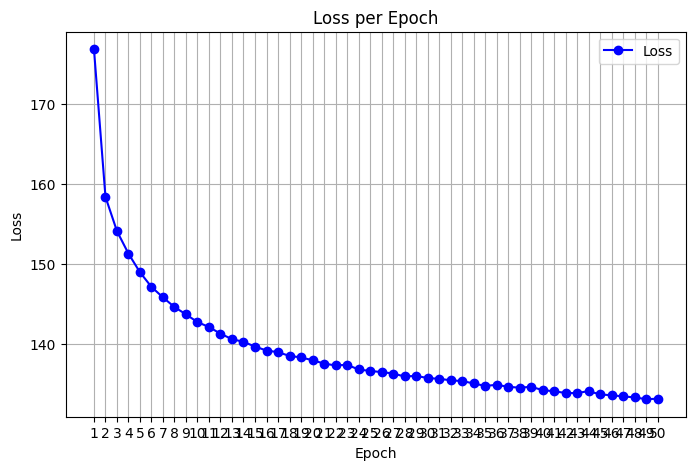

In [33]:
epochs = list(range(1, len(loss_list) + 1))

# Plotting the loss curve
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss_list, marker='o', linestyle='-', color='b', label='Loss')

# Labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.xticks(epochs)  # Ensure epoch numbers are correctly displayed
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

# Generate and plot digit

In [38]:
def generate_digit(mean, var):
    z = torch.tensor([[mean, var]], dtype=torch.float).to(device) # Z is sampeled from mean and variance space.
    x_decoded = model.decoder.forward(z) # Reconstruct an image using Z
    digit = x_decoded.detach().cpu().reshape(28, 28) # The Image
    def plot_digit(): # Plotting the image.
      plt.imshow(digit, cmap='gray')
      plt.axis('off')
      plt.show()
    plot_digit()

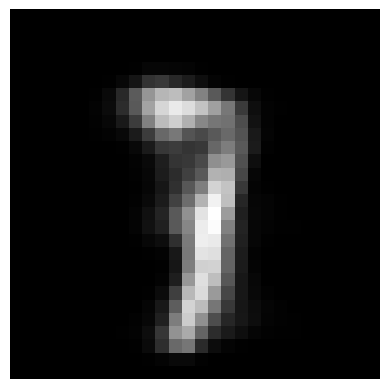

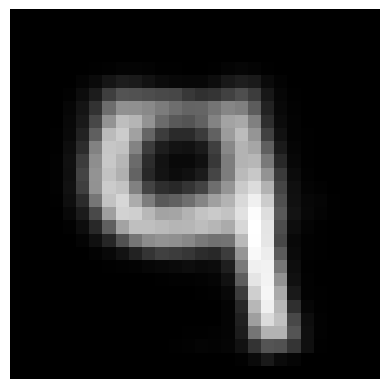

(None, None)

In [39]:
generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

# Latent Space Grid Visualization
This function visualizes the structure of the VAE’s latent space by generating a grid of reconstructed images.
It creates a 2D grid of latent space points between -scale and scale, evenly spaced along the x-axis (Mean) and y-axis (Variance).
For each latent vector in the grid:
- It passes the latent vector through the decoder.
- The decoder reconstructs an image corresponding to that point in latent space.
- The image is placed in a 30x30 grid, forming the latent space

In [34]:
def plot_latent_space(model, scale, digit_size=28, figsize=15):

    figure = np.zeros((digit_size *30, digit_size * 30)) # Create a blank plot of 30x30 images, each image of dim 28x28
    x_axis = np.linspace(-scale, scale, 30) # Helps in creating 30 evenly spaced images in the plot.
    y_axis = np.linspace(-scale, scale, 30)[::-1]

    for i, y_i in enumerate(y_axis): # Iterates over each point
        for j, x_i in enumerate(x_axis):
            z = torch.tensor([[x_i, y_i]], dtype=torch.float).to(device) # Z is a 2D latent vector
            x_decoded = model.decoder.forward(z) # Reconstruct image using Z
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size) # Tensor to numpy array

            row_start = i * digit_size # Digit place in figure calculation
            row_end = (i + 1) * digit_size
            col_start = j * digit_size
            col_end = (j + 1) * digit_size

            figure[row_start:row_end, col_start:col_end] = digit # Assign digit at right position.

    # Plotting the latent space
    plt.figure(figsize=(figsize, figsize))
    plt.title('Latent Space')
    start_range = digit_size // 2
    pixel_range = np.arange(start_range, 30 * digit_size + start_range, digit_size)
    plt.xticks(pixel_range, np.round(x_axis, 1))
    plt.yticks(pixel_range, np.round(y_axis, 1))
    plt.xlabel("Mean")
    plt.ylabel("Var")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()

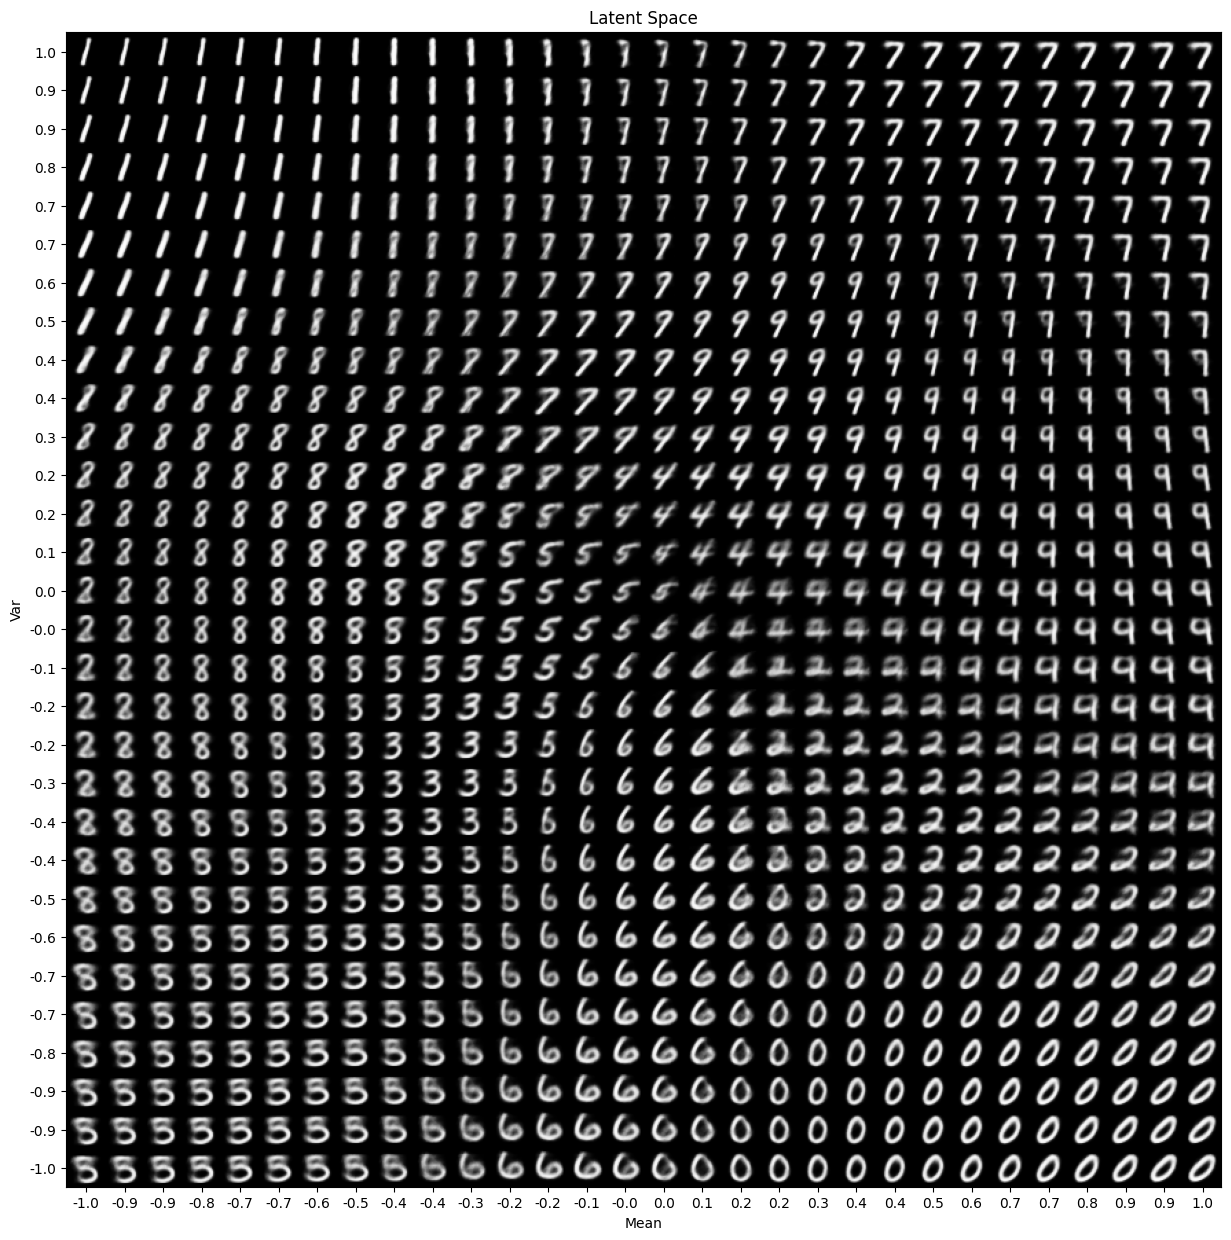

In [35]:
plot_latent_space(model, scale=1.0)

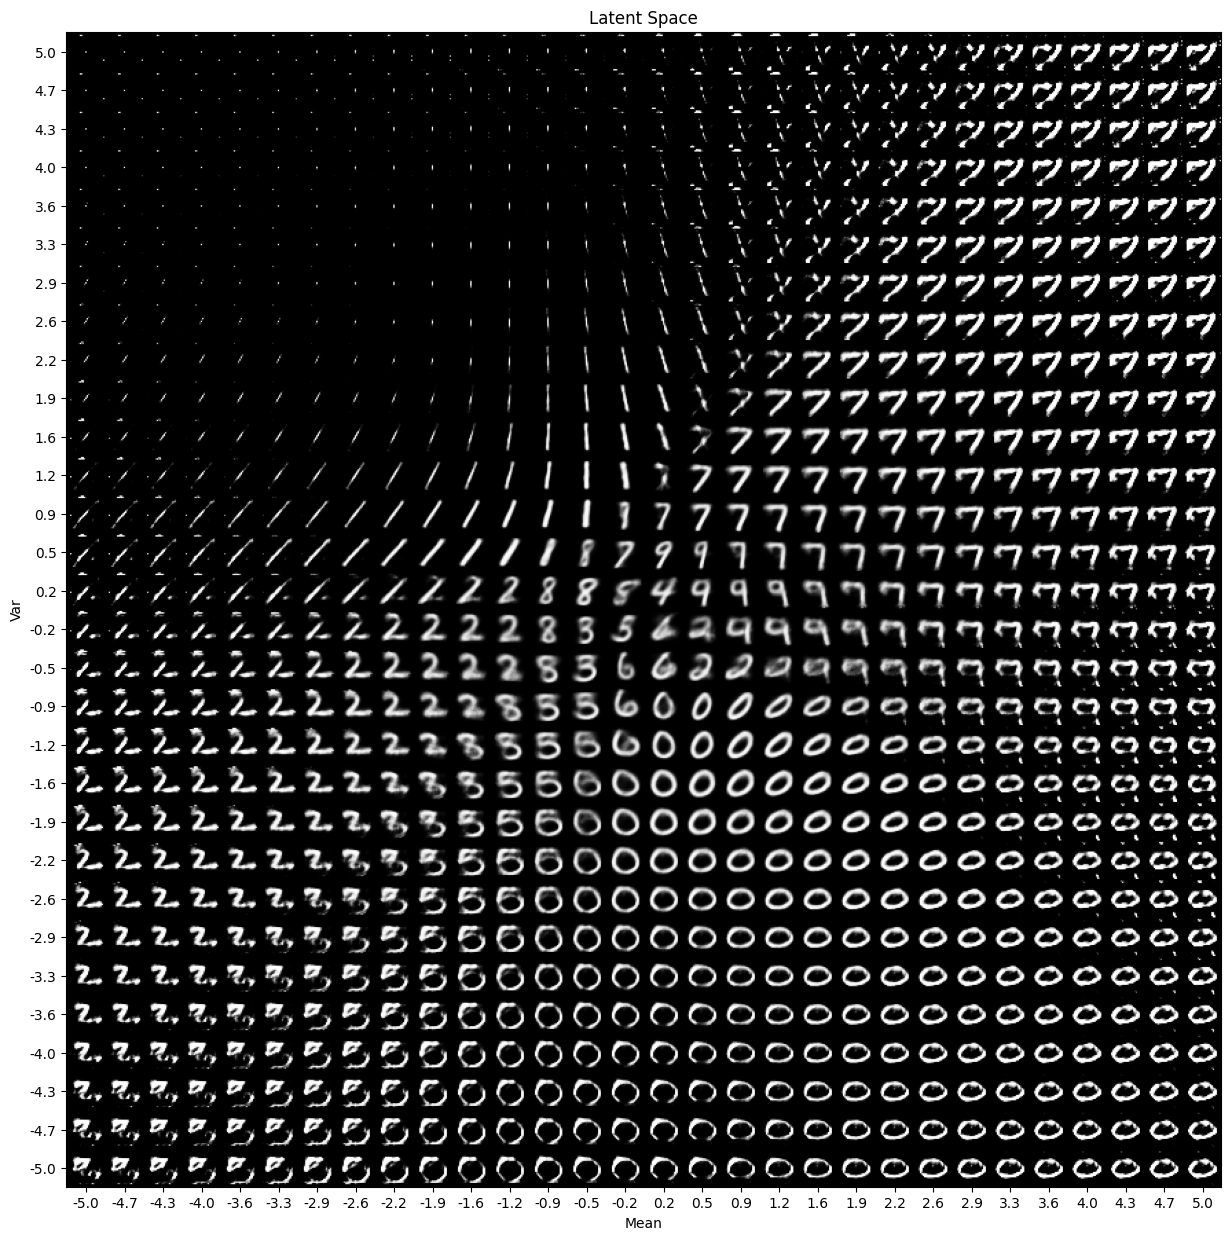

In [40]:
plot_latent_space(model, scale=5.0)

# Linear Interpolation
Performs latent space interpolation between two randomly sampled points.
- Generates a smooth transition between two latent vectors (mean1, var1 → mean2, var2).
- Uses generate_digit_return(mean, var) to create decoded images from interpolated latent points.


In [ ]:
def generate_digit_return(mean, var): # Same function implement above, but this returns the image.
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decoder.forward(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    return digit

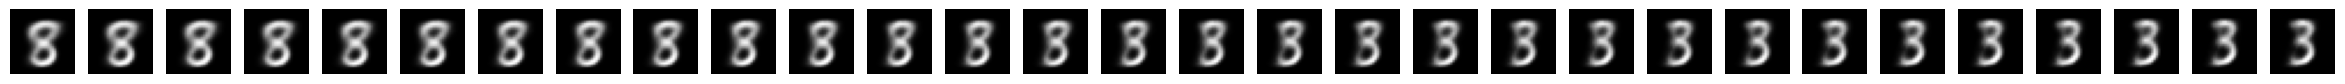

In [ ]:
num_steps = 30

mean1, var1 = np.random.randn(), np.random.randn() # Generate two random latent mean and variance
mean2, var2 = np.random.randn(), np.random.randn()

t_values = np.linspace(0, 1, num_steps) # Interpolation values.
interpolated_images = [] # Saves an array of images.

for t in t_values: # Linear Interpolation between the two latent vectors.
    mean_t = (1 - t) * mean1 + t * mean2
    var_t = (1 - t) * var1 + t * var2

    img = generate_digit_return(mean_t, var_t) # Reconstructs the image
    interpolated_images.append(img) # Adds to the array of images.

fig, axes = plt.subplots(1, num_steps, figsize=(num_steps, 2)) # Plot the interpolated images in a array
for i, ax in enumerate(axes):
    ax.imshow(interpolated_images[i].cpu().numpy(), cmap="gray")
    ax.axis("off")

plt.show()

# **Bonus**
Simply created an animation using the images generated.
Saved the array of images as an .mp4 and converted to an animation.
- Video runs at 2 FPS.

In [ ]:
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import HTML

height, width = interpolated_images[0].shape
fps = 2
video_filename = "output_video.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

out = cv2.VideoWriter(video_filename, fourcc, fps, (width, height), isColor=False)

for img in interpolated_images:
    if isinstance(img, torch.Tensor):
        img = img.cpu().numpy()

    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)

    out.write(img)

out.release()
print(f"Video saved as {video_filename}")


Video saved as output_video.mp4


In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
from IPython.display import HTML

def display_video(video):
    fig = plt.figure(figsize=(3,3))

    mov = []
    for i in range(len(video)):
        img = plt.imshow(video[i], animated=True)
        plt.axis('off')
        mov.append([img])

    anime = animation.ArtistAnimation(fig, mov, interval=50, repeat_delay=1000)

    plt.close()
    return anime

video = imageio.mimread('output_video.mp4')
HTML(display_video(video).to_html5_video())